パラメータ  
firstsize:初期個体数(population)  
life_length:寿命(year)  
cool_time:性成熟する年齢(year)  
x:初期集団のオスの性比(no unit)  
accident_rate:年間の事故での死亡割合(/year)  
born_rate:流産しない割合(?)  

その他  
iteration:世代数(year)  
Nmax:個体数上限(population)

初期性比を変化させて最終個体数の変化を見る

In [3]:
# ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import statistics
import os
import itertools
import math
np.random.seed(1)

In [4]:
# 個体クラスの定義
class Agent():
    def __init__(self, life_length, accident_rate):
        self.sex = np.random.choice(['m', 'f'])
        self.life_length = life_length
        self.age = 0
        self.death_rate = (1/life_length) + accident_rate # 年間の死亡割合

    # 歳を取る
    def aging(self):
        self.age += 1

    # 死亡判定処理
    def judge_death(self):
        # 寿命で死亡
        if self.age >= self.life_length:
            return True
        else:
            return np.random.choice([True, False], p=[self.death_rate, (1-self.death_rate)])

In [5]:
# シミュレーションクラスの定義

# firstsize:初期個体数、Nmax:個体数上限、life_length:寿命、cool_time:性成熟する年齢
# x:初期集団のオスの比率、accident_rate:年間の事故での死亡割合、born_rate:流産しない割合

class Simulation():
    def __init__(self, firstsize, Nmax, life_length, cool_time, x=0.5, accident_rate=0, born_rate=1):
        self.population = self.__initialize(firstsize, life_length, accident_rate, x)
        self.Nmax = Nmax
        self.life_length = life_length
        self.cool_time = cool_time
        self.accident_rate = accident_rate
        self.born_rate = born_rate

        self.cwd = os.getcwd()
        self.population_size = [firstsize]
        self.sexratio = [x]


    # 初期集団をつくる
    def __initialize(self, firstsize, life_length, accident_rate, x):
        population = []

        # firstsizeとxに従って初期集団をつくる
        # 初期集団の個体の年齢はランダムに決定
        for i in range(int(firstsize * x)):
            focal = Agent(life_length, accident_rate)
            focal.sex = 'm'
            focal.age = np.random.randint(life_length)
            population.append(focal)

        for i in range(int(firstsize * (1-x))):
            focal = Agent(life_length, accident_rate)
            focal.sex = 'f'
            focal.age = np.random.randint(0, life_length)
            population.append(focal)

        np.random.shuffle(population)
        
        return population


    # 集団内の交尾
    def __copulation(self):

        if len([focal for focal in self.population if (focal.sex == 'm') and (focal.age > self.cool_time)]) >= 1:

            # 生殖可能なメス個体
            female_population = [focal for focal in self.population if (focal.sex == 'f') and (focal.age > self.cool_time)]

            # 流産しない個体を選ぶ
            chosen_female = [focal for focal in female_population if np.random.rand() <= self.born_rate]
        
            # メスが子供を産む
            for _ in chosen_female:
                self.population.append(Agent(self.life_length, self.accident_rate))

            np.random.shuffle(self.population)


    # 一定の死亡率で死亡
    # 寿命で死亡
    def __aging_and_death(self):
        for focal in self.population:
            focal.aging()
            if focal.judge_death():
                index = self.population.index(focal)
                del self.population[index]


    # 個体数抑制
    def __population_control(self):
        while len(self.population) > int(self.Nmax):
            index = np.random.randint(0, len(self.population))
            del self.population[index]


    # 個体数、性比を記録する
    def __calculation(self):
        p_size = len(self.population)
        m_size = len([focal for focal in self.population if focal.sex == 'm'])

        if p_size != 0:
            s_ratio = (m_size / p_size)
        else:
            s_ratio = 0

        self.population_size.append(p_size)
        self.sexratio.append(s_ratio)

    
    # 世代のシミュレーションを実行
    def run_one_episode(self, iteration, episode):
        for _ in range(iteration):
            self.__copulation()
            self.__aging_and_death()
            self.__population_control()
            self.__calculation()

        pd.DataFrame({
            'population size': self.population_size,
            'sex ratio': self.sexratio
        }).to_csv(os.path.join(self.cwd, 'result', f'episode_{episode}.csv'))

In [6]:
# main処理
# 初期性比を変化させて最終個体数の変化を観察
def main():
    cwd = os.getcwd()
    os.makedirs(os.path.join(cwd, 'result'), exist_ok=True)

    # パラメータの設定
    iteration = 50
    firstsize = 100
    Nmax = 10000
    life_length = 30
    cool_time = 5
    sex_ratio_array = np.linspace(0, 1, 21)
    accident_rate = 0
    born_rate = 0.3

    with open('result/parameters.csv', mode='a') as f:
        f.write('episode,sex ratio\n')
        for i, S in enumerate(sex_ratio_array):
            print(f'episode:{i}, S:{S}')
            simulation = Simulation(firstsize, Nmax, life_length, cool_time, S, accident_rate, born_rate)
            simulation.run_one_episode(iteration, episode=i)
            f.write(f'{i},{S}\n')

if __name__ == '__main__':
    main()

episode:0, S:0.0
episode:1, S:0.05
episode:2, S:0.1
episode:3, S:0.15000000000000002
episode:4, S:0.2
episode:5, S:0.25
episode:6, S:0.30000000000000004
episode:7, S:0.35000000000000003
episode:8, S:0.4
episode:9, S:0.45
episode:10, S:0.5
episode:11, S:0.55
episode:12, S:0.6000000000000001
episode:13, S:0.65
episode:14, S:0.7000000000000001
episode:15, S:0.75
episode:16, S:0.8
episode:17, S:0.8500000000000001
episode:18, S:0.9
episode:19, S:0.9500000000000001
episode:20, S:1.0


/var/folders/_w/f4z7dgpj7ds3kb9z3rbqw3lc0000gn/T/ipykernel_1512/1333384319.py:34: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


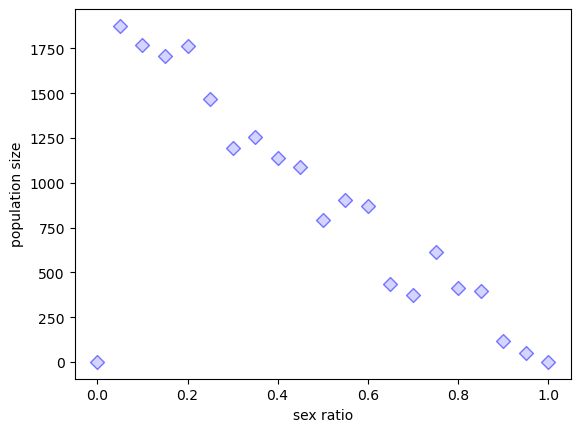

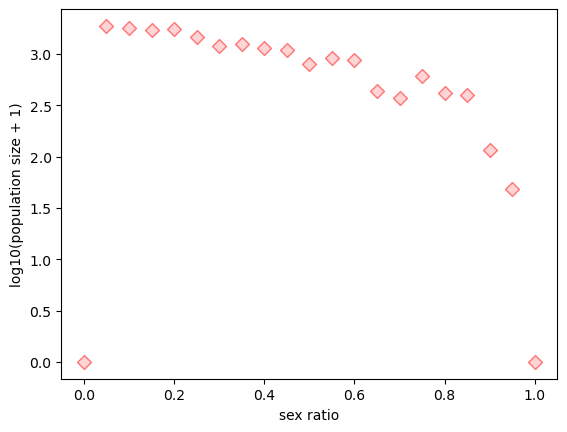

In [7]:
# 可視化
def main():
    # データの読み込み
    params = pd.read_csv('result/parameters.csv', index_col=0)
    s_ratio = params['sex ratio']
    population_size = []
    population_size_log = []
    
    # 各シミュレーションの最終個体数を取ってくる
    for i in range(21):                              # 手入力必須！！！！
        df = pd.read_csv(f'result/episode_{i}.csv')
        x = df['population size'][50]                # 世代数手入力必要
        population_size.append(x)
        population_size_log.append(math.log10(x+1))

    
    # 図1
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(s_ratio, population_size, s=50, alpha=0.5, linewidths=1, c='#aaaaFF', edgecolors='b', marker='D')
    ax.set_xlabel('sex ratio')
    ax.set_ylabel('population size')
    fig.savefig('tmp1.png', dpi=600)


    # 図2
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(s_ratio, population_size_log, s=50, alpha=0.5, linewidths=1, c='#FFaaaa', edgecolors='r', marker='D')
    ax.set_xlabel('sex ratio')
    ax.set_ylabel('log10(population size + 1)')
    fig.savefig('tmp2.png', dpi=600)

    fig.show()


if __name__ == '__main__':
    main()